<a href="https://colab.research.google.com/github/suyashss/nn_test/blob/master/BEE-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
tf.version

<module 'tensorflow_core._api.v2.version' from '/tensorflow-2.1.0/python3.6/tensorflow_core/_api/v2/version/__init__.py'>

In [0]:
import matplotlib.pyplot as plt
def display_images(images,n):
  #print(images.shape)
  fig = plt.figure(figsize=(n*1.5,3))
  for i in range(n):
    img = images[i,:,:]
    plt.subplot(1,n,i+1)
    plt.imshow(img,cmap="binary")
    plt.axis("off")
  plt.show()    

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving honey-bee-annotated-images.zip to honey-bee-annotated-images.zip
User uploaded file "honey-bee-annotated-images.zip" with length 52950294 bytes


In [10]:
!unzip honey-bee-annotated-images.zip

Archive:  honey-bee-annotated-images.zip
  inflating: bee_data.csv            
  inflating: bee_imgs/bee_imgs/001_043.png  
  inflating: bee_imgs/bee_imgs/001_044.png  
  inflating: bee_imgs/bee_imgs/001_046.png  
  inflating: bee_imgs/bee_imgs/001_047.png  
  inflating: bee_imgs/bee_imgs/001_050.png  
  inflating: bee_imgs/bee_imgs/001_051.png  
  inflating: bee_imgs/bee_imgs/001_054.png  
  inflating: bee_imgs/bee_imgs/001_056.png  
  inflating: bee_imgs/bee_imgs/001_078.png  
  inflating: bee_imgs/bee_imgs/001_082.png  
  inflating: bee_imgs/bee_imgs/001_083.png  
  inflating: bee_imgs/bee_imgs/001_085.png  
  inflating: bee_imgs/bee_imgs/001_091.png  
  inflating: bee_imgs/bee_imgs/001_092.png  
  inflating: bee_imgs/bee_imgs/001_093.png  
  inflating: bee_imgs/bee_imgs/001_094.png  
  inflating: bee_imgs/bee_imgs/001_095.png  
  inflating: bee_imgs/bee_imgs/001_096.png  
  inflating: bee_imgs/bee_imgs/001_097.png  
  inflating: bee_imgs/bee_imgs/001_118.png  
  inflating: bee_imgs

In [0]:
img_test = keras.preprocessing.image.load_img('bee_imgs/bee_imgs/046_197.png')

In [12]:
#%matplotlib inline
img_test.size

(44, 53)

In [0]:
img_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True)

In [14]:
train_generator = img_gen.flow_from_directory(
          './bee_imgs/', target_size=(30, 30),
      batch_size=12,color_mode='grayscale',)

Found 5172 images belonging to 1 classes.


In [41]:
5172 % 12, 5172 /12

(0, 431.0)

In [0]:
(x_train,y_train)= train_generator.next()

In [16]:
x_train.shape,y_train.shape

((12, 30, 30, 1), (12, 1))

In [17]:
x_train[1,2,3,:]

array([0.97647065], dtype=float32)

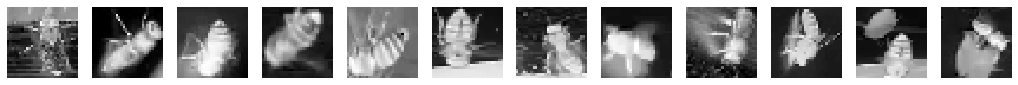

In [18]:
display_images(x_train.squeeze(),12)

In [19]:
type(x_train[0,0][0])

numpy.ndarray

In [20]:
x_train.shape

(12, 30, 30, 1)

In [0]:
batch_size=12

In [0]:
codings_size = 60

In [0]:
generator = keras.models.Sequential([
                                     keras.layers.Dense(100,activation="selu",input_shape=[codings_size]),
                                     keras.layers.Dense(150,activation="selu"),
                                     keras.layers.Dense(150,activation="selu"),
                                     keras.layers.Dense(30*30,activation="sigmoid"),
                                     keras.layers.Reshape([30,30,1])
])

In [24]:
tgen = generator(tf.random.normal(shape=[batch_size,codings_size]))
print(tgen.shape)

(12, 30, 30, 1)


In [0]:
discriminator = keras.models.Sequential([keras.layers.Conv2D(64,input_shape=[30,30,1],kernel_size=(2,2),strides=2,),
                                         keras.layers.Flatten(),
                                          keras.layers.Dense(150,activation="selu"),
                                      keras.layers.Dense(100,activation="selu"),
                                      keras.layers.Dense(1,activation="sigmoid"),
])

In [0]:
gan = keras.models.Sequential([generator,discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=1e-4))
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=1e-4))

In [0]:
def train_gan(gan,train_generator,batch_size,codings_size,n_epochs=50,num_batches=100):
  generator,discriminator = gan.layers
  for epoch in range(n_epochs):
    for batch in range(num_batches):
      (X_batch,y_batch) = train_generator.next()
      #print("Shape is",X_batch.shape)
      # Train discriminator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      generated_images = generator(noise)
      if (epoch+1) % 20 == 0 and batch==0:
        print("Epoch is",epoch+1,"GAN loss is",loss,"Discriminator loss is",disc_loss)
        display_images(tf.squeeze(generated_images),12)
      X_fake_and_real = tf.concat([generated_images,X_batch],axis=0)
      y1 = tf.constant([[0.1]]*batch_size + [[0.9]]*batch_size)
      discriminator.trainable = True
      #disc_loss = discriminator.train_on_batch(X_fake_and_real,y1)
      disc_loss = discriminator.train_on_batch(generated_images,tf.constant([[0.1]]*batch_size))
      disc_loss += discriminator.train_on_batch(X_batch,tf.constant([[0.9]]*batch_size))
      disc_loss /= 2 
      # Train the generator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      y2 = tf.constant([[0.9]]*batch_size)
      discriminator.trainable = False
      loss = gan.train_on_batch(noise,y2)

Epoch is 20 GAN loss is 0.9363139 Discriminator loss is 0.6061532497406006


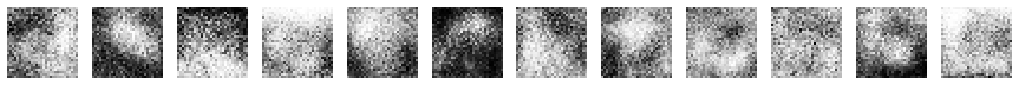

Epoch is 40 GAN loss is 0.8861294 Discriminator loss is 0.548092246055603


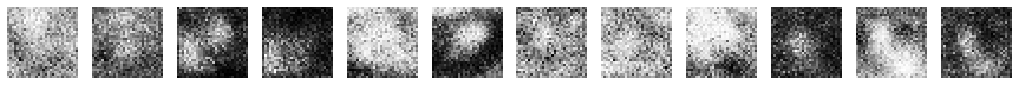

Epoch is 60 GAN loss is 0.8420957 Discriminator loss is 0.5519696474075317


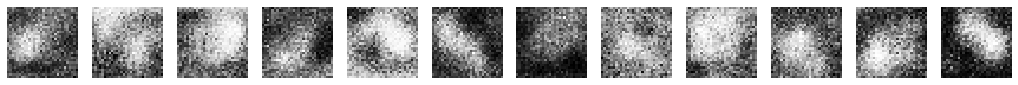

Epoch is 80 GAN loss is 0.8143354 Discriminator loss is 0.6611945033073425


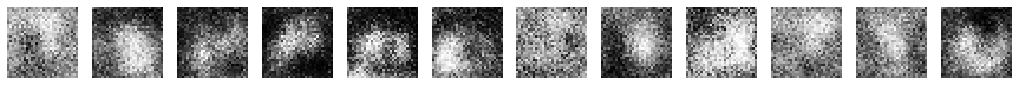

Epoch is 100 GAN loss is 0.7234251 Discriminator loss is 0.6268514394760132


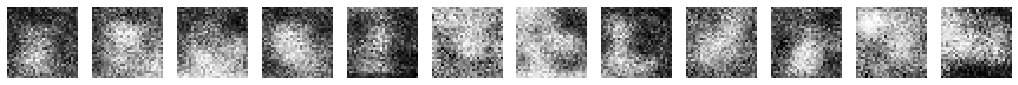

Epoch is 120 GAN loss is 0.91772467 Discriminator loss is 0.714496374130249


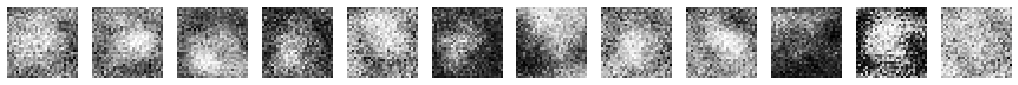

Epoch is 140 GAN loss is 0.9090324 Discriminator loss is 0.6095961332321167


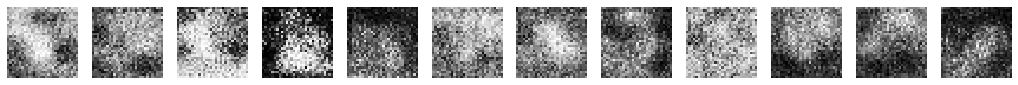

Epoch is 160 GAN loss is 0.82973033 Discriminator loss is 0.6454144716262817


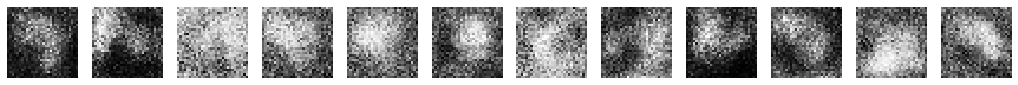

Epoch is 180 GAN loss is 0.8280671 Discriminator loss is 0.6873455047607422


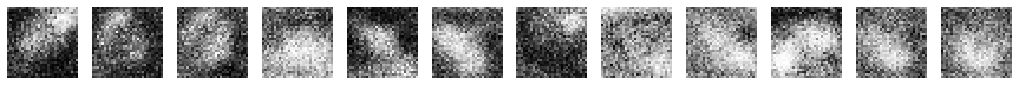

Epoch is 200 GAN loss is 0.8422828 Discriminator loss is 0.6070846915245056


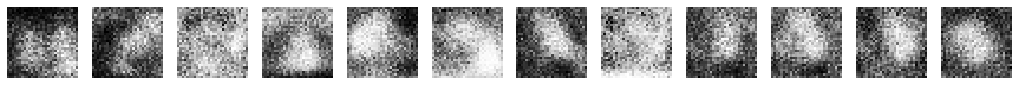

Epoch is 220 GAN loss is 0.7806899 Discriminator loss is 0.6233185529708862


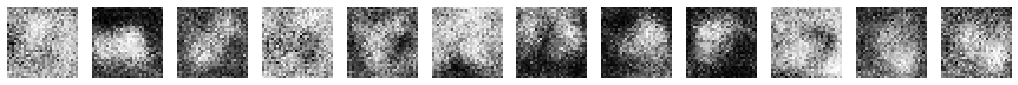

Epoch is 240 GAN loss is 0.9483919 Discriminator loss is 0.6201721429824829


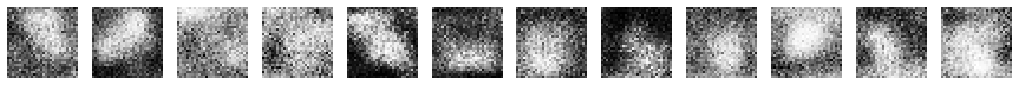

Epoch is 260 GAN loss is 0.8599096 Discriminator loss is 0.631234884262085


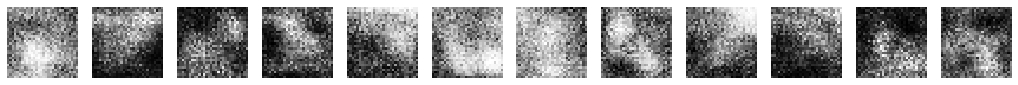

Epoch is 280 GAN loss is 0.80831605 Discriminator loss is 0.604426383972168


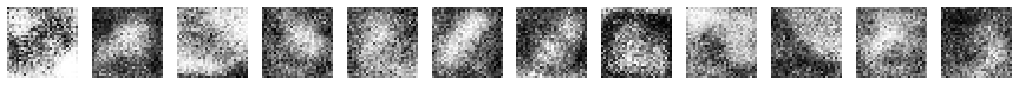

Epoch is 300 GAN loss is 0.96420383 Discriminator loss is 0.6286356449127197


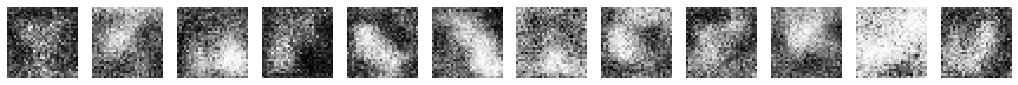

In [48]:
train_gan(gan,train_generator,batch_size,codings_size,300,num_batches=100)